In [1]:
using PyPlot, SeisPlot
using FFTW
using LinearAlgebra
using DSP, MAT
using Random
using SeisProcessing

In [13]:
include("BlendOpFreq.jl")
include("FastHankelMultply.jl")
include("Hankelization.jl")
include("Anti_Diagonal_Average.jl")
include("SeisFSSA.jl")
include("SeisMSSA.jl")
include("SeisRandomQR.jl")
include("Ricker.jl")
include("SeisLocal.jl")
include("SeisLocalPatch.jl")
include("SeisRadontimePara.jl")
include("ApplyTaper.jl")
include("SeisUnlocal.jl")

SeisUnlocal

In [2]:
# -Read data
path = "new_output_train_bf2.bin"  # path to the file
fp   = open(path, "r")               # open the file
nt  =1751   # number of samples per traces
nr  = 183       # number of receivers per shot
ns  = 808       # number of shots
data1 = zeros(Float64, nt * nr * ns)  # allocate memory
read!(fp, data1) 

258909864-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  0.0                  
  ⋮                    
 -0.09989672899246216  
 -0.12197321653366089  
 -0.04418352618813515  
  0.028635770082473755 
  0.019744064658880234 
 -0.03142143040895462  
 -0.06424331665039062  
 -0.05521412938833237  
 -0.007470864802598953 
  0.02716909721493721  
 -0.0012222274672240019
 -0.0471830740571022   

In [4]:
data = reshape(data1,nt,nr,ns)
size(data)

(1751, 183, 808)

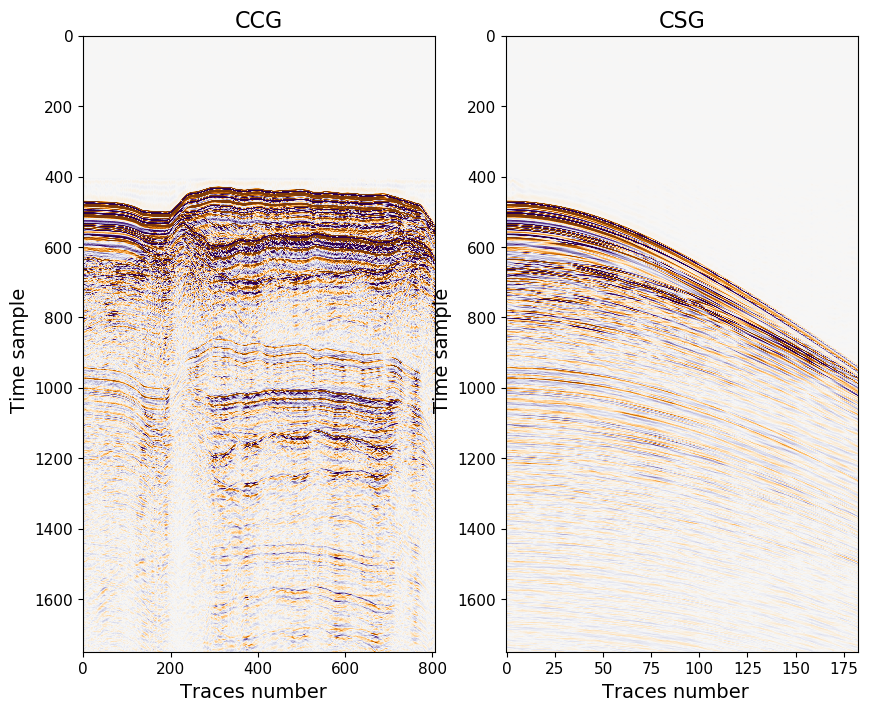

PyObject <matplotlib.image.AxesImage object at 0x7efd61d83e10>

In [8]:
close("all")
vm=1
figure(1, figsize=(10, 8))
subplot(121);SeisPlotTX(data[:,5,:], title="CCG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(122);SeisPlotTX(data[:,:,5], title="CSG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


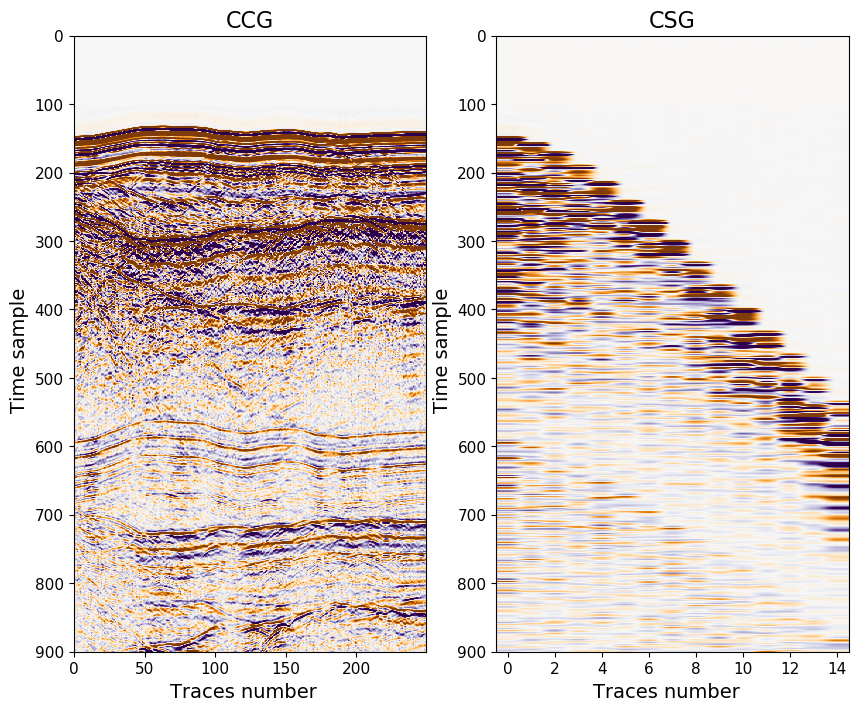

PyObject <matplotlib.image.AxesImage object at 0x7efd4f0cd510>

In [83]:
# Extract small size of the real data
D0 = data[300:1200,10:10:150,251:500];
close("all")
vm=1
figure(1, figsize=(10, 8))
subplot(121);SeisPlotTX(D0[:,1,:], title="CCG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(122);SeisPlotTX(D0[:,:,1], title="CSG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [84]:
(nt,nr,ns) = size(D0)
dt = 0.004
Random.seed!(1234)
################# FOR blending_forward_adjoint2 Test [nt,nr,ns]##########################
QD0 = (norm(D0))^2;

jtime = rand(ns)*0.5*nt*dt ;

b = BlendOpFreq(D0,false;ns=ns,nr=nr,nt=nt,jtime=jtime);
D1 = BlendOpFreq(b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)


901×15×250 Array{Float64,3}:
[:, :, 1] =
  7.98174e-6   1.48864e-5  -6.37426e-7  …   6.73678e-6   1.74814e-5
 -7.94171e-6  -1.47998e-5   6.27722e-7     -6.70521e-6  -1.74055e-5
  7.90175e-6   1.47134e-5  -6.18013e-7      6.67369e-6   1.73298e-5
 -7.86183e-6  -1.4627e-5    6.08299e-7     -6.64221e-6  -1.72542e-5
  7.82197e-6   1.45407e-5  -5.9858e-7       6.61079e-6   1.71787e-5
 -7.78216e-6  -1.44545e-5   5.88855e-7  …  -6.57941e-6  -1.71034e-5
  7.7424e-6    1.43684e-5  -5.79124e-7      6.54807e-6   1.70282e-5
 -7.7027e-6   -1.42823e-5   5.69388e-7     -6.51679e-6  -1.69531e-5
  7.66304e-6   1.41964e-5  -5.59644e-7      6.48554e-6   1.68782e-5
 -7.62344e-6  -1.41105e-5   5.49895e-7     -6.45435e-6  -1.68034e-5
  7.58388e-6   1.40247e-5  -5.40139e-7  …   6.4232e-6    1.67287e-5
 -7.54438e-6  -1.39389e-5   5.30375e-7     -6.39209e-6  -1.66541e-5
  7.50493e-6   1.38533e-5  -5.20605e-7      6.36103e-6   1.65797e-5
  ⋮                                     ⋱                          
 -0.146

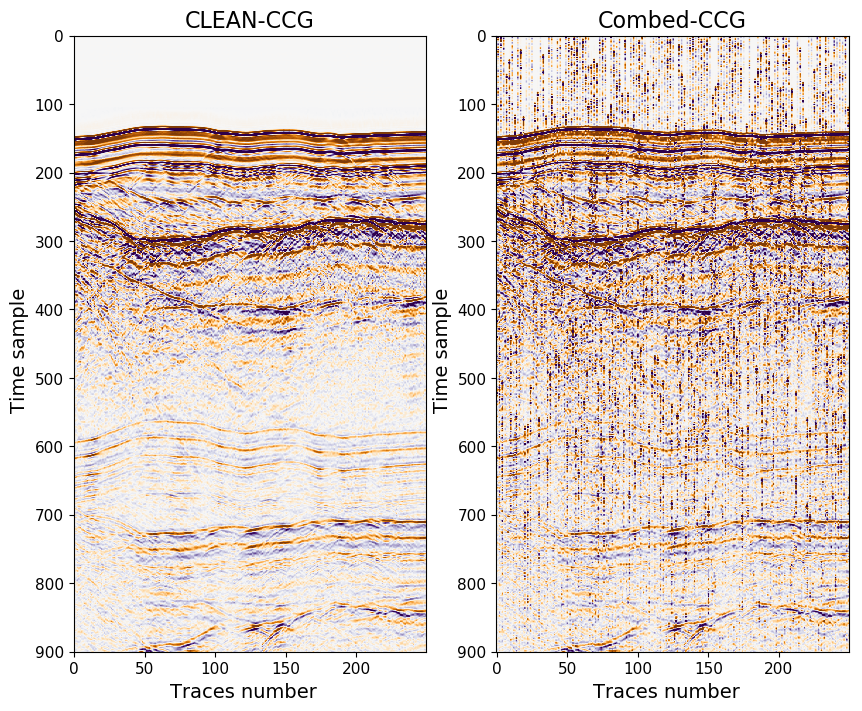

PyObject <matplotlib.image.AxesImage object at 0x7efd4f01c910>

In [85]:
close("all")
vm=2
figure(1, figsize=(10, 8))
subplot(121);SeisPlotTX(D0[:,1,:], title="CLEAN-CCG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(122);SeisPlotTX(D1[:,1,:], title="Combed-CCG", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [86]:
size(D1)

(901, 15, 250)

In [116]:
#Test for deblending
iter = 30
lamda1 = 0.5
rk    = 2
QD3 = zeros(iter);
QS3 = zeros(iter)

D3    = copy(D1);
D4    = copy(D1);
@time for i = 1:iter
    global D3
    global lamda1
    lamda = lamda1/sqrt(i)
    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp3 = BlendOpFreq(b3-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z3 = D3 - lamda.*Dtemp3;
    for ir = 1:nr
        param1 = Dict(:order=>"2D", :dt=>0.004,:it_WL=>200,:it_WO=>25,:dx1=>1,:ix1_WL=>25,:ix1_WO=>30,:x1min=>1,:x1max=>250);
        (zout,Minval,Maxval) = SeisLocal(z3[:,ir,:]; param1...)
        pzout = zeros(eltype(zout),size(zout))
        if rem(i,16)==0
            global rk
            rk = rk+1
        end
        for ip = 1 : size(zout,ndims(zout))
            pzout[:,:,ip] = SeisRandomQR(zout[:,:,ip], rk; dt=0.004, flow=1.0, fhigh=125.0, order="2D")
        end
        Dpzout = SeisUnlocal(pzout,Minval,Maxval,nt; param1...)
        D3[:,ir,:] =  Dpzout;
    end


    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e3 = b - b3
    error3 = dot(vec(e3), vec(e3));
    println(error3)
    QD3[i] = (norm(D0-D3))^2
    QS3[i] = 10*log10(QD0/QD3[i])
end

Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
238140.5542042217
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
254377.86669108574
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches

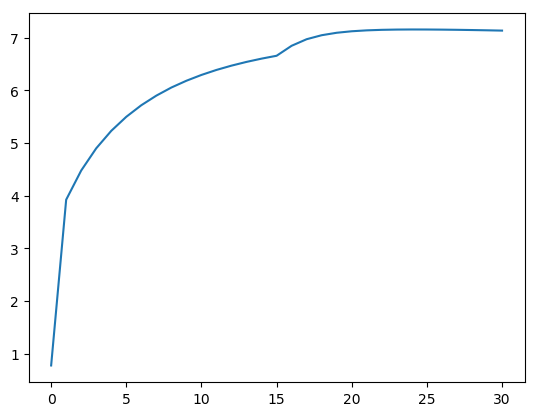

0.7766462748003609


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efd4ac12310>

In [117]:
QD1 = (norm(D0-D1))^2
QS1 = 10*log10(QD0/QD1)

println(QS1)
QQS3 = zeros(length(QS3)+1)
QQS3[2:end] = QS3;
QQS3[1] = QS1;
plot(QQS3)

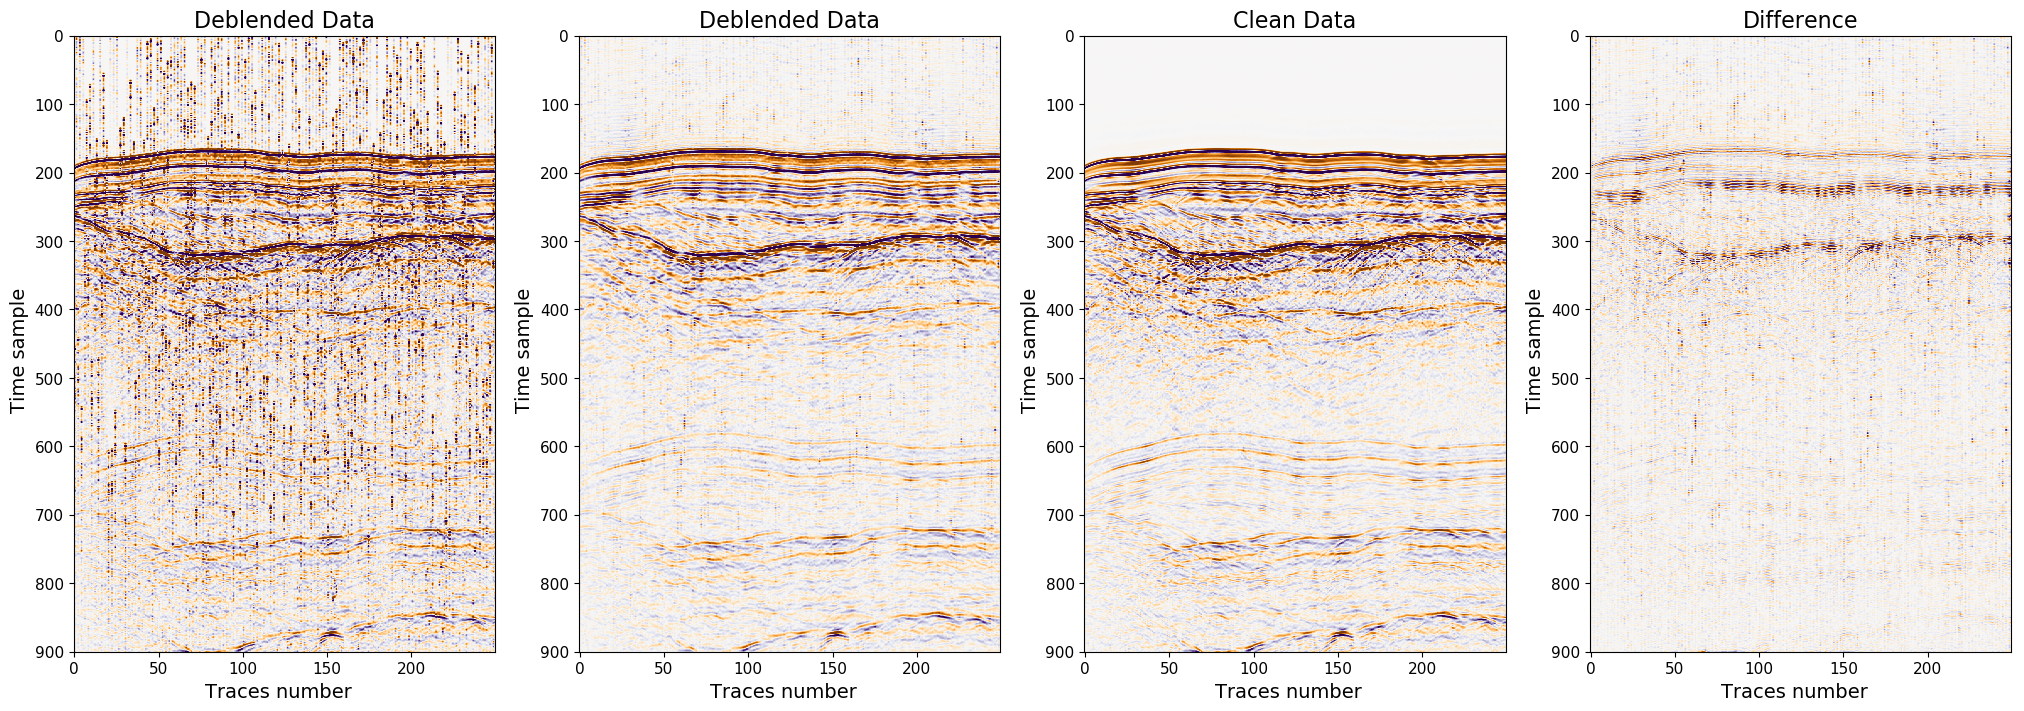

PyObject <matplotlib.image.AxesImage object at 0x7efd4a820290>

In [120]:
figure(3, figsize=(25, 8));
vm=2;
subplot(141);SeisPlotTX(D1[:,4,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D3[:,4,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D0[:,4,:], title="Clean Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D3[:,4,:]-D0[:,4,:], title="Difference", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [121]:
#Test for deblending
iter = 30
lamda1 = 0.5
rk    = 2
QD3 = zeros(iter);
QS3 = zeros(iter)

D3    = copy(D1);
D4    = copy(D1);
@time for i = 1:iter
    global D3
    global lamda1
    lamda = lamda1/sqrt(i)
    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp3 = BlendOpFreq(b3-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z3 = D3 - lamda.*Dtemp3;
    for ir = 1:nr
        param1 = Dict(:order=>"2D", :dt=>0.004,:it_WL=>200,:it_WO=>25,:dx1=>1,:ix1_WL=>25,:ix1_WO=>30,:x1min=>1,:x1max=>250);
        (zout,Minval,Maxval) = SeisLocal(z3[:,ir,:]; param1...)
        pzout = zeros(eltype(zout),size(zout))
#         if rem(i,10)==0
#             global rk
#             rk = rk+1
#         end
        for ip = 1 : size(zout,ndims(zout))
            pzout[:,:,ip] = SeisFSSA(zout[:,:,ip],rk,0.004,1.0,125.0; order="2D")
        end
        Dpzout = SeisUnlocal(pzout,Minval,Maxval,nt; param1...)
        D3[:,ir,:] =  Dpzout;
    end


    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e3 = b - b3
    error3 = dot(vec(e3), vec(e3));
    println(error3)
    QD3[i] = (norm(D0-D3))^2
    QS3[i] = 10*log10(QD0/QD3[i])
end

Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
280181.83122715366
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
296625.87239966646
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patches= 90
Number of patche

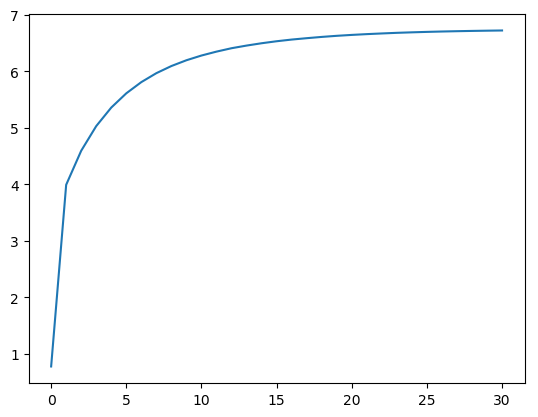

0.7766462748003609


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efd4a2e4a50>

In [123]:
QD1 = (norm(D0-D1))^2
QS1 = 10*log10(QD0/QD1)

println(QS1)
QQS3 = zeros(length(QS3)+1)
QQS3[2:end] = QS3;
QQS3[1] = QS1;
plot(QQS3)

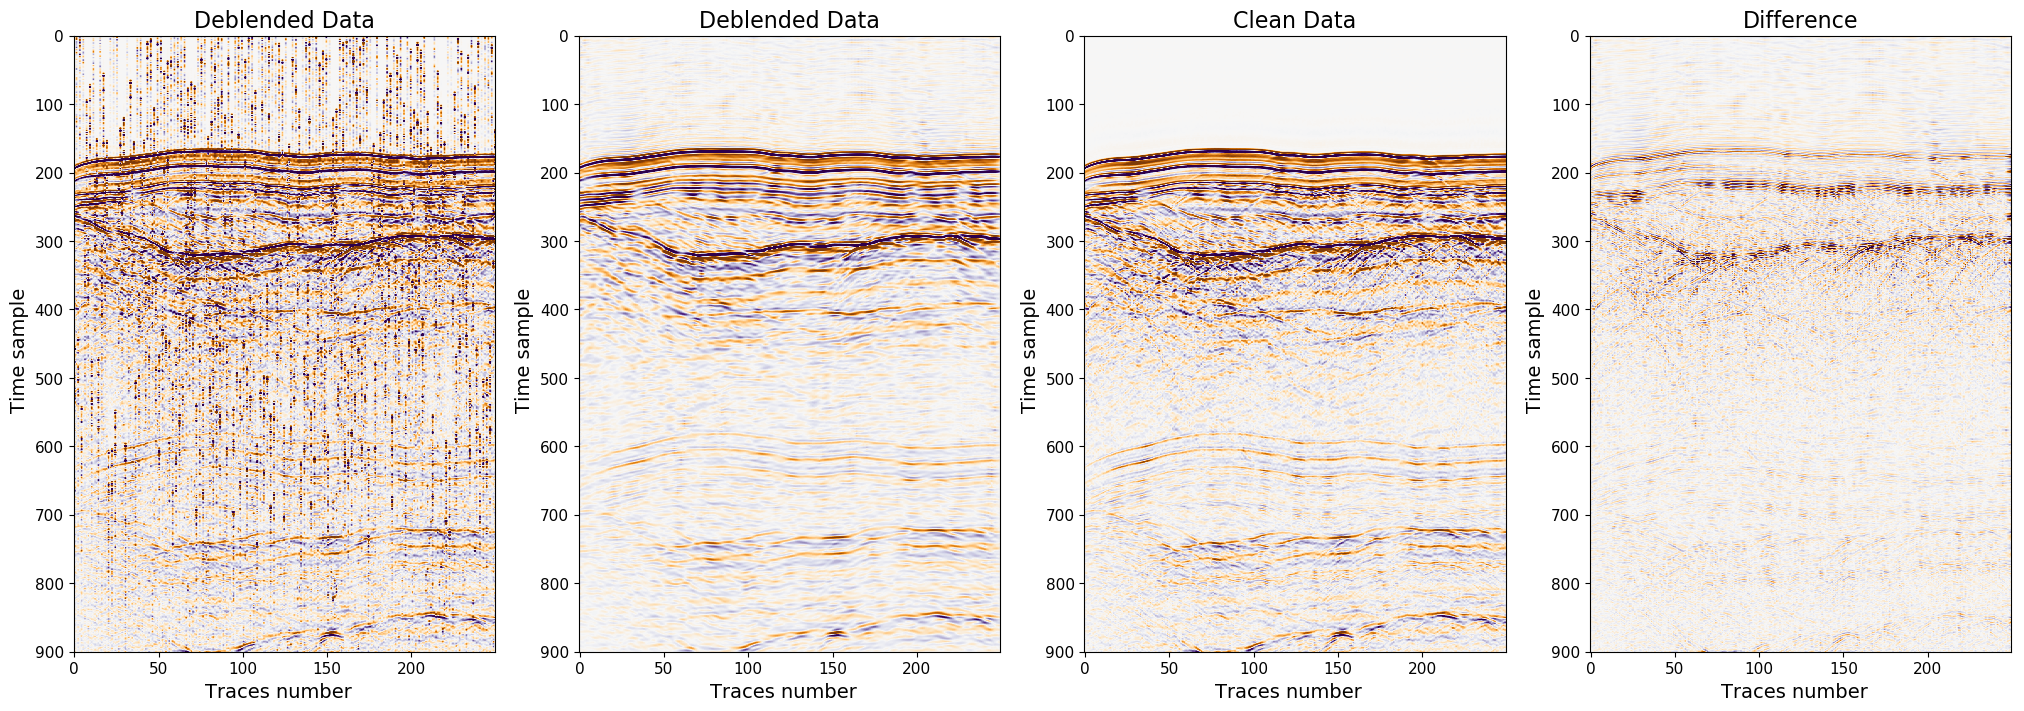

PyObject <matplotlib.image.AxesImage object at 0x7efd4a1c9150>

In [124]:
figure(3, figsize=(25, 8));
vm=2;
subplot(141);SeisPlotTX(D1[:,4,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D3[:,4,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D0[:,4,:],  title="Clean Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D3[:,4,:]-D0[:,4,:], title="Difference", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
